In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt
import scipy.stats as stats
from scipy import stats
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)
connection = engine.connect()

# Exploratory Climate Analysis

Last Date Found: 2017-08-23, so Date one Year Prior: 2016-08-23


,prcp,station
date,,
2016-08-23,0.00,USC00519397
2016-08-23,0.02,USC00519523
2016-08-23,0.05,USC00514830
2016-08-23,0.70,USC00516128
2016-08-23,0.15,USC00513117


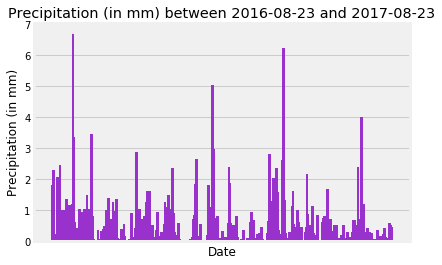

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# I will be using both, the pandas.read_sql option and the session.query option as they are interchangeble
# For min, max, avg, count etc. queries I'll use session.query, for the larger datasets and pandas I'll use the read_sql method

get_last_date = session.query(func.max(Measurement.date))
for d in get_last_date:
    d_date = d[0]

max_date = d_date
max_year = int(max_date[0:4])
min_year = str(max_year-1)
min_date = max_date.replace(str(max_year),str(min_year))
print(f"Last Date Found: {max_date}, so Date one Year Prior: {min_date}")

# Perform a query to retrieve the data and precipitation scores
sql_precip = ("SELECT prcp, station, date FROM measurement WHERE date between '" + min_date + "' and '" + max_date + "';")

# Save the query results as a Pandas DataFrame and set the index to the date column
df_precip = pd.read_sql(sql_precip, con=connection)
df_precip = df_precip.set_index('date')
df_precip = df_precip.dropna(how='any')

# Sort the dataframe by date
df_precip = df_precip.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = df_precip.index
y_axis = df_precip.prcp

plt.bar(x_axis, y_axis, color = 'darkorchid', width = 3)
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Precipitation (in mm)") # I think mm since the average rainfall in Hawaii was about 17 Inches total in 2017 - source: Google
plt.title(f"Precipitation (in mm) between {min_date} and {max_date}")
df_precip.head()

![precipitation](Images/precipitation.png)

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_precip.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [10]:
# Design a query to show how many stations are available in this dataset?
df_stations_new = session.query(Station.station, func.count(Station.station))
for i in df_stations_new:
    stat_count = i[1]
print(f"Number of Stations {stat_count}")

Number of Stations 9


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sql_act_stations = "SELECT s.name, s.station, COUNT(m.tobs) as measurements FROM measurement m INNER JOIN station s ON m.station=s.station \
                    GROUP BY s.name, s.station ORDER BY COUNT(m.tobs) DESC"
df_stations = pd.read_sql_query(sql_act_stations, con=connection)

max_station = df_stations.iloc[0,0]
max_station_id = df_stations.iloc[0,1]
print(f"Station {max_station}, ({max_station_id}) is the most active station")
df_stations

Station WAIHEE 837.5, HI US, (USC00519281) is the most active station


,name,station,measurements
0,"WAIHEE 837.5, HI US",USC00519281,2772
1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,"KANEOHE 838.1, HI US",USC00513117,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,"PEARL CITY, HI US",USC00517948,1372
8,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
df_most_active = session.query(*sel).filter(Measurement.station == max_station_id).all()

for d in df_most_active:
    d_station = d[0]
    d_min = d[1]
    d_max = d[2]
    d_avg = round(d[3],2)
    
print(f"The most active station {d_station} in the previous year had:")
print(f"Minimum temperature of {d_min}°F")
print(f"Maximum temperature of {d_max}°F")
print(f"Average temperature of {d_avg}°F")

The most active station USC00519281 in the previous year had:
Minimum temperature of 54.0°F
Maximum temperature of 85.0°F
Average temperature of 71.66°F


Text(0.5, 1.0, 'Temperature Frequency for USC00519281 over the past year')

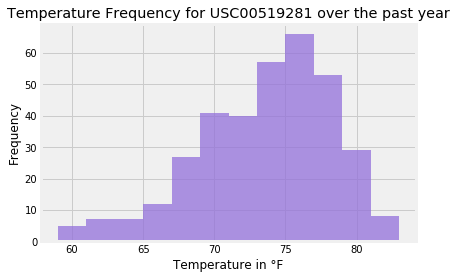

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station, Measurement.tobs]
df_tobs = pd.DataFrame(session.query(*sel).filter(Measurement.station == max_station_id). \
                            filter(Measurement.date >= min_date).filter(Measurement.date <= max_date).all())

# Just for the heck of it, get the station name without the mumbo jumbo
station_name = df_tobs.iloc[0,0]
station_name = str.split(station_name," ")
station_name = station_name[0]

x_axis = df_tobs['tobs']
plt.hist(x_axis, 12, facecolor='mediumpurple', alpha=0.75)
plt.xlabel("Temperature in °F")
plt.ylabel("Frequency")
plt.title("Temperature Frequency for " + station_name + " over the past year")

![precipitation](Images/station-histogram.png)

# Daily Rainfall Average

In [14]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# start_date = input("Start Date of your Trip: ")
# end_date = input("End Date of your Trip: ")
start_date = '2018-02-05'
end_date = '2018-02-15'

# Use the start and end date to create a range of dates
date_range = []
var_date = start_date
date_range.append(var_date)

while var_date < end_date:
    loc_date = datetime.strptime(var_date, "%Y-%m-%d")
    modified_date = loc_date + timedelta(days=1)
    var_date = datetime.strftime(modified_date, "%Y-%m-%d")
    date_range.append(var_date)

date_range

# Stip off the year and save a list of %m-%d strings
strip_range = []
for d in date_range:
    strip_string = d[5:]
    strip_range.append(strip_string)

strip_range

# Loop through the list of %m-%d strings and calculate the normals for each date
for s in strip_range:
    output = daily_normals(s)
    print(s , output)

02-05 [(59.0, 69.6842105263158, 80.0)]
02-06 [(58.0, 70.38983050847457, 77.0)]
02-07 [(60.0, 69.0, 77.0)]
02-08 [(56.0, 66.75438596491227, 74.0)]
02-09 [(57.0, 67.58928571428571, 75.0)]
02-10 [(56.0, 68.41666666666667, 76.0)]
02-11 [(61.0, 69.25, 79.0)]
02-12 [(60.0, 69.15789473684211, 78.0)]
02-13 [(58.0, 70.36206896551724, 80.0)]
02-14 [(62.0, 70.89473684210526, 79.0)]
02-15 [(56.0, 70.28813559322033, 79.0)]


In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_results = pd.DataFrame(date_range)
df_results = df_results.rename(columns={0:"Date"})
df_results = df_results.set_index("Date")

list_min = []
list_avg = []
list_max = []
for s in strip_range:
    daily = daily_normals(s)
    for d in daily:
        list_min_s = d[0]
        list_min.append(list_min_s)
        list_avg_s = d[1]
        list_avg.append(list_avg_s)
        list_max_s = d[2]
        list_max.append(list_max_s)
df_results['Minimum'] = list_min
df_results['Average'] = list_avg
df_results['Maximum'] = list_max

df_results

,Minimum,Average,Maximum
Date,,,
2018-02-05,59.0,69.684211,80.0
2018-02-06,58.0,70.389831,77.0
2018-02-07,60.0,69.000000,77.0
2018-02-08,56.0,66.754386,74.0
2018-02-09,57.0,67.589286,75.0
2018-02-10,56.0,68.416667,76.0
2018-02-11,61.0,69.250000,79.0
2018-02-12,60.0,69.157895,78.0
2018-02-13,58.0,70.362069,80.0


# Temperature Analysis I

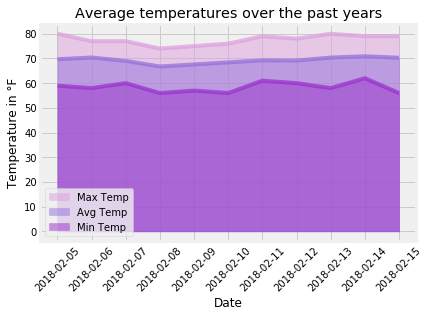

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
plot_date = df_results.index
plot_min = df_results['Minimum']
plot_avg = df_results['Average']
plot_max = df_results['Maximum']

plt.fill_between(plot_date, plot_max, color="plum",
                 alpha=0.5, label='Max Temp')
plt.plot(plot_date, plot_max, alpha=0.75, color="plum")
plt.fill_between(plot_date, plot_avg, color="mediumpurple",
                 alpha=0.5, label='Avg Temp')
plt.plot(plot_date, plot_avg, alpha=0.75, color="mediumpurple")
plt.fill_between(plot_date, plot_min, color="darkorchid",
                 alpha=0.5, label='Min Temp')
plt.plot(plot_date, plot_min, alpha=0.75, color="darkorchid")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Temperature in °F")
plt.title("Average temperatures over the past years")
plt.xticks(plot_date, rotation=45)
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?
def get_montly_averages(month):
    """List of Monthly Averages
    
    Args:
        date (str): A date string indicating a month number in the format '%MM'
        
    Returns:
        A list of tuples containing the daily tavg
    
    """
    get_range = []
    i = 1

    while i <= 31:
        if i <= 9:
            get_data = daily_normals(str(month) + '-0' + str(i))
        else:
            get_data = daily_normals(str(month) + '-' + str(i))
        for d in get_data:
            if d[0] is not 'None':
                get_range.append(d[1])
        i = i+1

    return get_range

In [20]:
# month1 = input("First month (MM): ")
# month2 = input("Second month (MM): ")

month1 = '06'
month2 = '12'

df1 = pd.DataFrame(get_montly_averages(month1))
df2 = pd.DataFrame(get_montly_averages(month2))

df1 = df1.dropna(how='any')
df2 = df2.dropna(how='any')

In [21]:
stats.ttest_ind(df1[0].fillna(0) , df2[0].fillna(0), equal_var=False)

Ttest_indResult(statistic=17.619694805351532, pvalue=5.093309139082608e-22)

# Temperature Analysis II

In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
data_for_chart = calc_temps(min_date, max_date)
print(calc_temps(min_date, max_date))
print(f"From: {min_date}")
print(f"To: {max_date}")

[(58.0, 74.59058295964125, 87.0)]
From: 2016-08-23
To: 2017-08-23


C:\Users\dutch\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<ErrorbarContainer object of 3 artists>

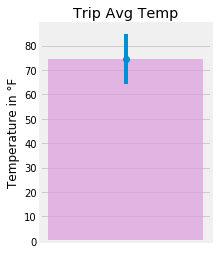

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 1
range = []
for d in data_for_chart:
    y = d[1]
    yerr = np.std([d[0],d[2]])/np.sqrt(2)

ax1 = plt.subplot(1,2,1)
ax1.bar(x, y, width=0.5, bottom=None, align='center', color = 'plum', alpha = 0.75)
# plt.xlabel("")
plt.xticks([])
plt.ylabel("Temperature in °F")
plt.title("Trip Avg Temp")

ax2 = plt.subplot(1,2,1)
ax2.errorbar(x, y, yerr, fmt="o")


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def get_rainfall(start_date, end_date):
    """Total rainfall per weather station for given dates -/- a year
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        Station name, Station id, Rainfall, Latitude, Longetude, Elevation
    """
    start_year = int(start_date[0:4]) 
    last_start_year = int(start_date[0:4])-1
    end_year = int(end_date[0:4])
    last_end_year = int(end_date[0:4])-1
    start_date_ly = start_date.replace(str(start_year),str(last_start_year))
    end_date_ly = end_date.replace(str(end_year),str(last_end_year))
    print(f"Start Date Current Year: {start_date}")
    print(f"End Date Current Year: {end_date}")
    print(f"Start Date Previous Year: {start_date_ly}")
    print(f"End Date Previous Year: {end_date_ly}")
    
    sql_rainfall = "SELECT s.station, s.name, SUM(m.prcp) as rainfall, s.latitude, s.longitude, s.elevation \
                    FROM measurement m INNER JOIN station s ON m.station=s.station \
                    WHERE m.date between'" + start_date_ly + "' and '" + end_date_ly + "' \
                    GROUP BY s.name, s.station, s.latitude, s.longitude, s.elevation \
                    ORDER BY SUM(m.prcp) DESC"
    
    return pd.read_sql(sql_rainfall, con=connection)

get_rainfall('2017-05-05', '2017-05-14')


Start Date Current Year: 2017-05-05
End Date Current Year: 2017-05-14
Start Date Previous Year: 2016-05-05
End Date Previous Year: 2016-05-14


,station,name,rainfall,latitude,longitude,elevation
0,USC00513117,"KANEOHE 838.1, HI US",3.60,21.42340,-157.80150,14.6
1,USC00519281,"WAIHEE 837.5, HI US",3.27,21.45167,-157.84889,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.90,21.33556,-157.71139,19.5
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",2.07,21.33310,-157.80250,152.4
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.56,21.52130,-157.83740,7.0
5,USC00517948,"PEARL CITY, HI US",0.44,21.39340,-157.97510,11.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.16,21.27160,-157.81680,3.0
